#  Procesado FoodMart

## Carga de datos

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sidetable
from pathlib import Path

In [21]:
basepath = Path.cwd() / '00 - datasets' / 'FoodMart'

In [29]:
# Creo diccionario de dataframes para tener centralizados los csv
csvlist = list(basepath.glob('*.csv'))
dataset = {csvlist[i].stem : pd.read_csv(csvlist[i]) for i in range(len(csvlist))}

store = dataset['Store-Lookup']
region = dataset['Region-Lookup']
product = dataset['Product-Lookup']
transactions98 = dataset['FoodMart-Transactions-1998']
transactions97 = dataset['FoodMart-Transactions-1997']
returns = dataset['FoodMart-Returns-1997-1998']
customer = dataset['Customer-Lookup']
calendar = dataset['Calendar-Lookup']

## Tratamiento de datos

Tratamiento de fechas, concatenar ficheros, crear calendario, construir modelo en estrella vs. copo de nieve

In [23]:
# store['first_opened_date'] = pd.to_datetime(store['first_opened_date'])
# store['last_remodel_date'] = pd.to_datetime(store['last_remodel_date'])
store[['first_opened_date', 'last_remodel_date']] = store[[
    'first_opened_date', 'last_remodel_date']].apply(pd.to_datetime, errors='coerce')

store.dtypes

store_id                         int64
region_id                        int64
store_type                      object
store_name                      object
store_street_address            object
store_city                      object
store_state                     object
store_country                   object
store_phone                     object
first_opened_date       datetime64[ns]
last_remodel_date       datetime64[ns]
total_sqft                       int64
grocery_sqft                     int64
dtype: object

In [24]:
# Concatenamos y formateamos fechas correctamente
transactions = pd.concat([transactions97, transactions98])

transactions[['transaction_date', 'stock_date']] = transactions[[
    'transaction_date', 'stock_date']].apply(pd.to_datetime, errors='coerce')

transactions.dtypes

transaction_date    datetime64[ns]
stock_date          datetime64[ns]
product_id                   int64
customer_id                  int64
store_id                     int64
quantity                     int64
dtype: object

In [105]:
returns['return_date'] = pd.to_datetime(returns['return_date'], errors='coerce')
returns.dtypes

return_date    datetime64[ns]
product_id              int64
store_id                int64
quantity                int64
dtype: object

In [59]:
# Creamos tabla calendario
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['year'] = calendar['date'].dt.year
calendar['month'] = calendar['date'].dt.month
calendar['day'] = calendar['date'].dt.day
calendar['Q'] = calendar['date'].dt.quarter
calendar['dayname'] = calendar['date'].dt.day_name()
calendar['weekday'] = calendar['date'].dt.weekday
calendar['week'] = calendar['date'].dt.isocalendar().week.astype('int64')
calendar.head()

,date,year,month,day,Q,dayname,week,weekday
0,1997-01-01,1997,1,1,1,Wednesday,1,2
1,1997-01-02,1997,1,2,1,Thursday,1,3
2,1997-01-03,1997,1,3,1,Friday,1,4
3,1997-01-04,1997,1,4,1,Saturday,1,5
4,1997-01-05,1997,1,5,1,Sunday,1,6


In [30]:
customer[['birthdate','acct_open_date']] = customer[['birthdate','acct_open_date']].apply(pd.to_datetime, errors='coerce')
customer.dtypes

customer_id                         int64
customer_acct_num                   int64
first_name                         object
last_name                          object
customer_address                   object
customer_city                      object
customer_state_province            object
customer_postal_code                int64
customer_country                   object
birthdate                  datetime64[ns]
marital_status                     object
yearly_income                      object
gender                             object
total_children                      int64
num_children_at_home                int64
education                          object
acct_open_date             datetime64[ns]
member_card                        object
occupation                         object
homeowner                          object
dtype: object

In [61]:
product.stb.counts()

,count,unique,most_freq,most_freq_count,least_freq,least_freq_count
recyclable,873,1,1,873,1,873
low_fat,552,1,1,552,1,552
product_brand,1560,111,Hermanos,44,Prelude,1
product_cost,1560,173,0.25,24,1.94,1
product_retail_price,1560,315,2.65,15,3.28,1
product_weight,1560,376,17.1,17,7.88,1
product_id,1560,1560,1560,1,1560,1
product_name,1560,1560,Cormorant Plastic Knives,1,Cormorant Plastic Knives,1
product_sku,1560,1560,78262181878,1,78262181878,1


## Fusión de datos en estrella

In [72]:
transactions.columns


Index(['transaction_date', 'stock_date', 'product_id', 'customer_id',
       'store_id', 'quantity'],
      dtype='object')

In [71]:
product.columns

Index(['product_id', 'product_brand', 'product_name', 'product_sku',
       'product_retail_price', 'product_cost', 'product_weight', 'recyclable',
       'low_fat'],
      dtype='object')

In [103]:
cincomejores=(transactions
              .merge(product)
              .groupby('product_brand')['quantity']
              .sum()
              .nlargest(5)
              .index
              .tolist()
             )
cincomejores

['Hermanos', 'Tell Tale', 'Ebony', 'Tri-State', 'High Top']

In [94]:
agregadaproducto = transactions.merge(product)
df = agregadaproducto[agregadaproducto['product_brand'].isin(cincomejores)]

In [102]:
df.shape

(38041, 14)

In [112]:
returns.groupby(pd.Grouper(key='return_date',freq='M'))['quantity'].sum()

return_date
1997-01-31    221
1997-02-28    191
1997-03-31    238
1997-04-30    186
1997-05-31    215
1997-06-30    221
1997-07-31    222
1997-08-31    216
1997-09-30    198
1997-10-31    228
1997-11-30    240
1997-12-31    262
1998-01-31    472
1998-02-28    470
1998-03-31    459
1998-04-30    442
1998-05-31    429
1998-06-30    453
1998-07-31    467
1998-08-31    410
1998-09-30    462
1998-10-31    455
1998-11-30    563
1998-12-31    569
Freq: M, Name: quantity, dtype: int64

In [121]:
returns.merge(calendar, left_on='return_date', right_on='date').groupby(['year', 'month'])['quantity'].sum().unstack(level=0).mean(axis=1)

month
1     346.5
2     330.5
3     348.5
4     314.0
5     322.0
6     337.0
7     344.5
8     313.0
9     330.0
10    341.5
11    401.5
12    415.5
dtype: float64

## Otras tareas

* Realizar varias consultas contra la tabla de transacciones
* Realizar algunos gráficos

In [31]:
transaccionesancha = transactions.merge(store)

<AxesSubplot:ylabel='store_city'>

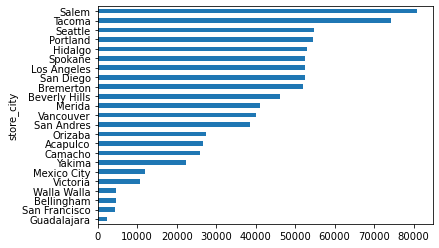

In [50]:
transaccionesancha.groupby('store_city')['quantity'].sum().sort_values().plot.barh()

Para clientes

In [54]:
transactions.merge(customer).groupby('first_name')['quantity'].sum().sort_values(ascending=False)

first_name
John         14559
James        13551
Robert       12568
Mary         10781
Michael       8933
             ...  
Loren            2
Emyril           2
Della            2
Roselinda        1
Zina             1
Name: quantity, Length: 2101, dtype: int64

## Guardamos csv a disco